<a href="https://colab.research.google.com/github/Dimonfordont/DS_course/blob/main/Basics/Data_analysis/Boston_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Boston housing dataset to train linear models

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score, r2_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [ ]:
house_data = fetch_openml(name='boston')

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:301: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X = pd.DataFrame(house_data['data'], columns=house_data['feature_names'])
y = house_data['target']

## EDA

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    float64 
 5   RM       506 non-null    float64 
 6   AGE      506 non-null    float64 
 7   DIS      506 non-null    float64 
 8   RAD      506 non-null    category
 9   TAX      506 non-null    float64 
 10  PTRATIO  506 non-null    float64 
 11  B        506 non-null    float64 
 12  LSTAT    506 non-null    float64 
dtypes: category(2), float64(11)
memory usage: 45.1 KB


We got 506 rows and 13 columns + 1 target columns. "object" data types have been already changed to "category".

No NaNs are seen in the dataset so far.

Let's change float64 to float32 for faster computations (on a dataset this small, we won't even notice it)

In [ ]:
for col in X.columns:
  if X[col].dtype == 'float64':
    X[col] = X[col].astype('float32')

In [ ]:
X.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136780,0.554695,6.284634,68.574898,3.795043,408.237152,18.455534,356.674042,12.653064
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537109,2.164946,91.294861,7.141061
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377487,6.950000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440002,11.360000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.074999,5.188425,666.000000,20.200001,396.225006,16.954999
max,88.976196,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.899994,37.970001


We can see that the columns have been already encoded from categorical to numeric values.

All the features are:

CRIM - crime rate per capita

ZN - residential land / lots over 25k sq.ft.

INDUS - non-rental business acres/town

CHAS - adjested to Charles river or not

NOX - nitric oxides concentration (parts per 10 mil)

RM - avg num of rooms per house

AGE - owner occupied unit built before 1940 / total

DIS - weighted distance to 5 boston employment centers

RAD - index accessibility to radial roads

TAX - property tax rate / $10k

PTRATIO - student/teacher by town

B:  "1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town" Now you know why this dataset has been depricated. Boo! Boo!

LSTAT: - % lower status of the population

array([[<Axes: title={'center': 'CRIM'}>, <Axes: title={'center': 'ZN'}>,
        <Axes: title={'center': 'INDUS'}>],
       [<Axes: title={'center': 'NOX'}>, <Axes: title={'center': 'RM'}>,
        <Axes: title={'center': 'AGE'}>],
       [<Axes: title={'center': 'DIS'}>, <Axes: title={'center': 'TAX'}>,
        <Axes: title={'center': 'PTRATIO'}>],
       [<Axes: title={'center': 'B'}>, <Axes: title={'center': 'LSTAT'}>,
        <Axes: >]], dtype=object)

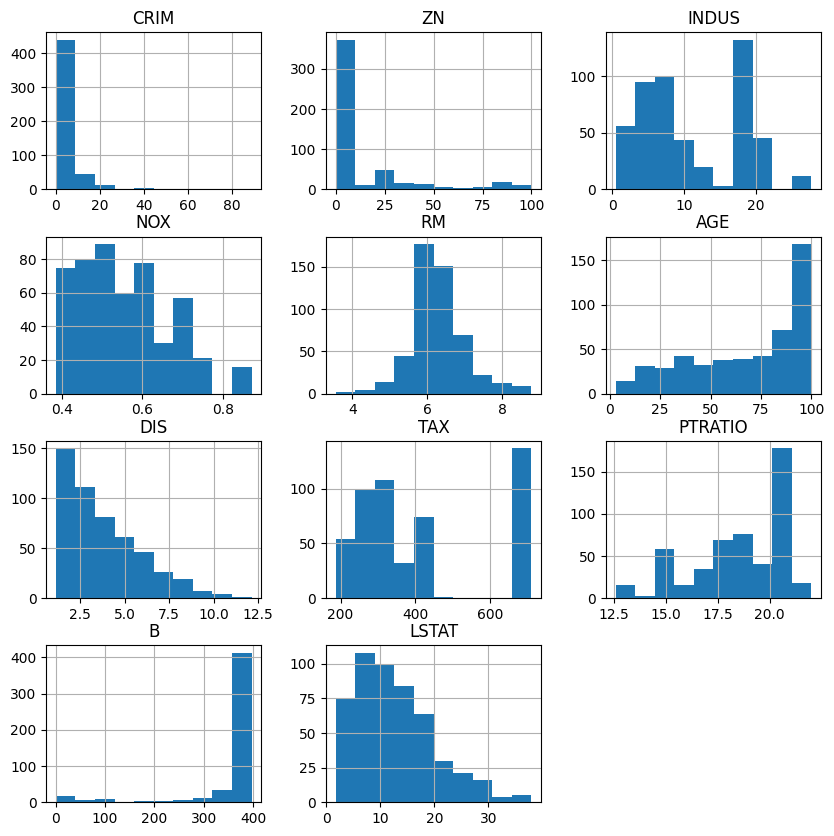

In [ ]:
X.hist(X.columns, figsize=(10, 10))

#Check correlation

<ipython-input-603-a6aac71589b5>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ds_corr = dataset.corr().round(2)


<Axes: >

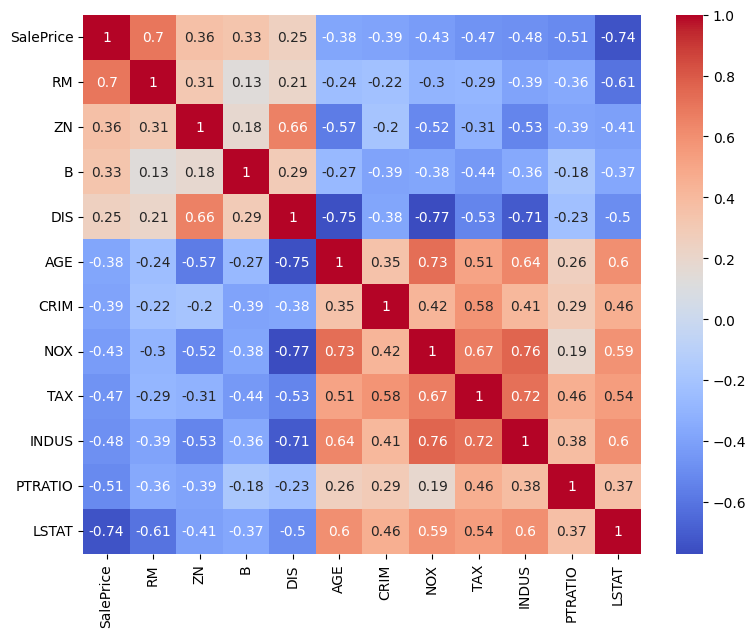

In [ ]:
dataset = X.copy()
dataset['SalePrice'] = y
fig, ax = plt.subplots(figsize=(9, 7))

ds_corr = dataset.corr().round(2)
corr_target = ds_corr['SalePrice'].sort_values(ascending=False)
corr = ds_corr.loc[corr_target.index, corr_target.index]

sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)

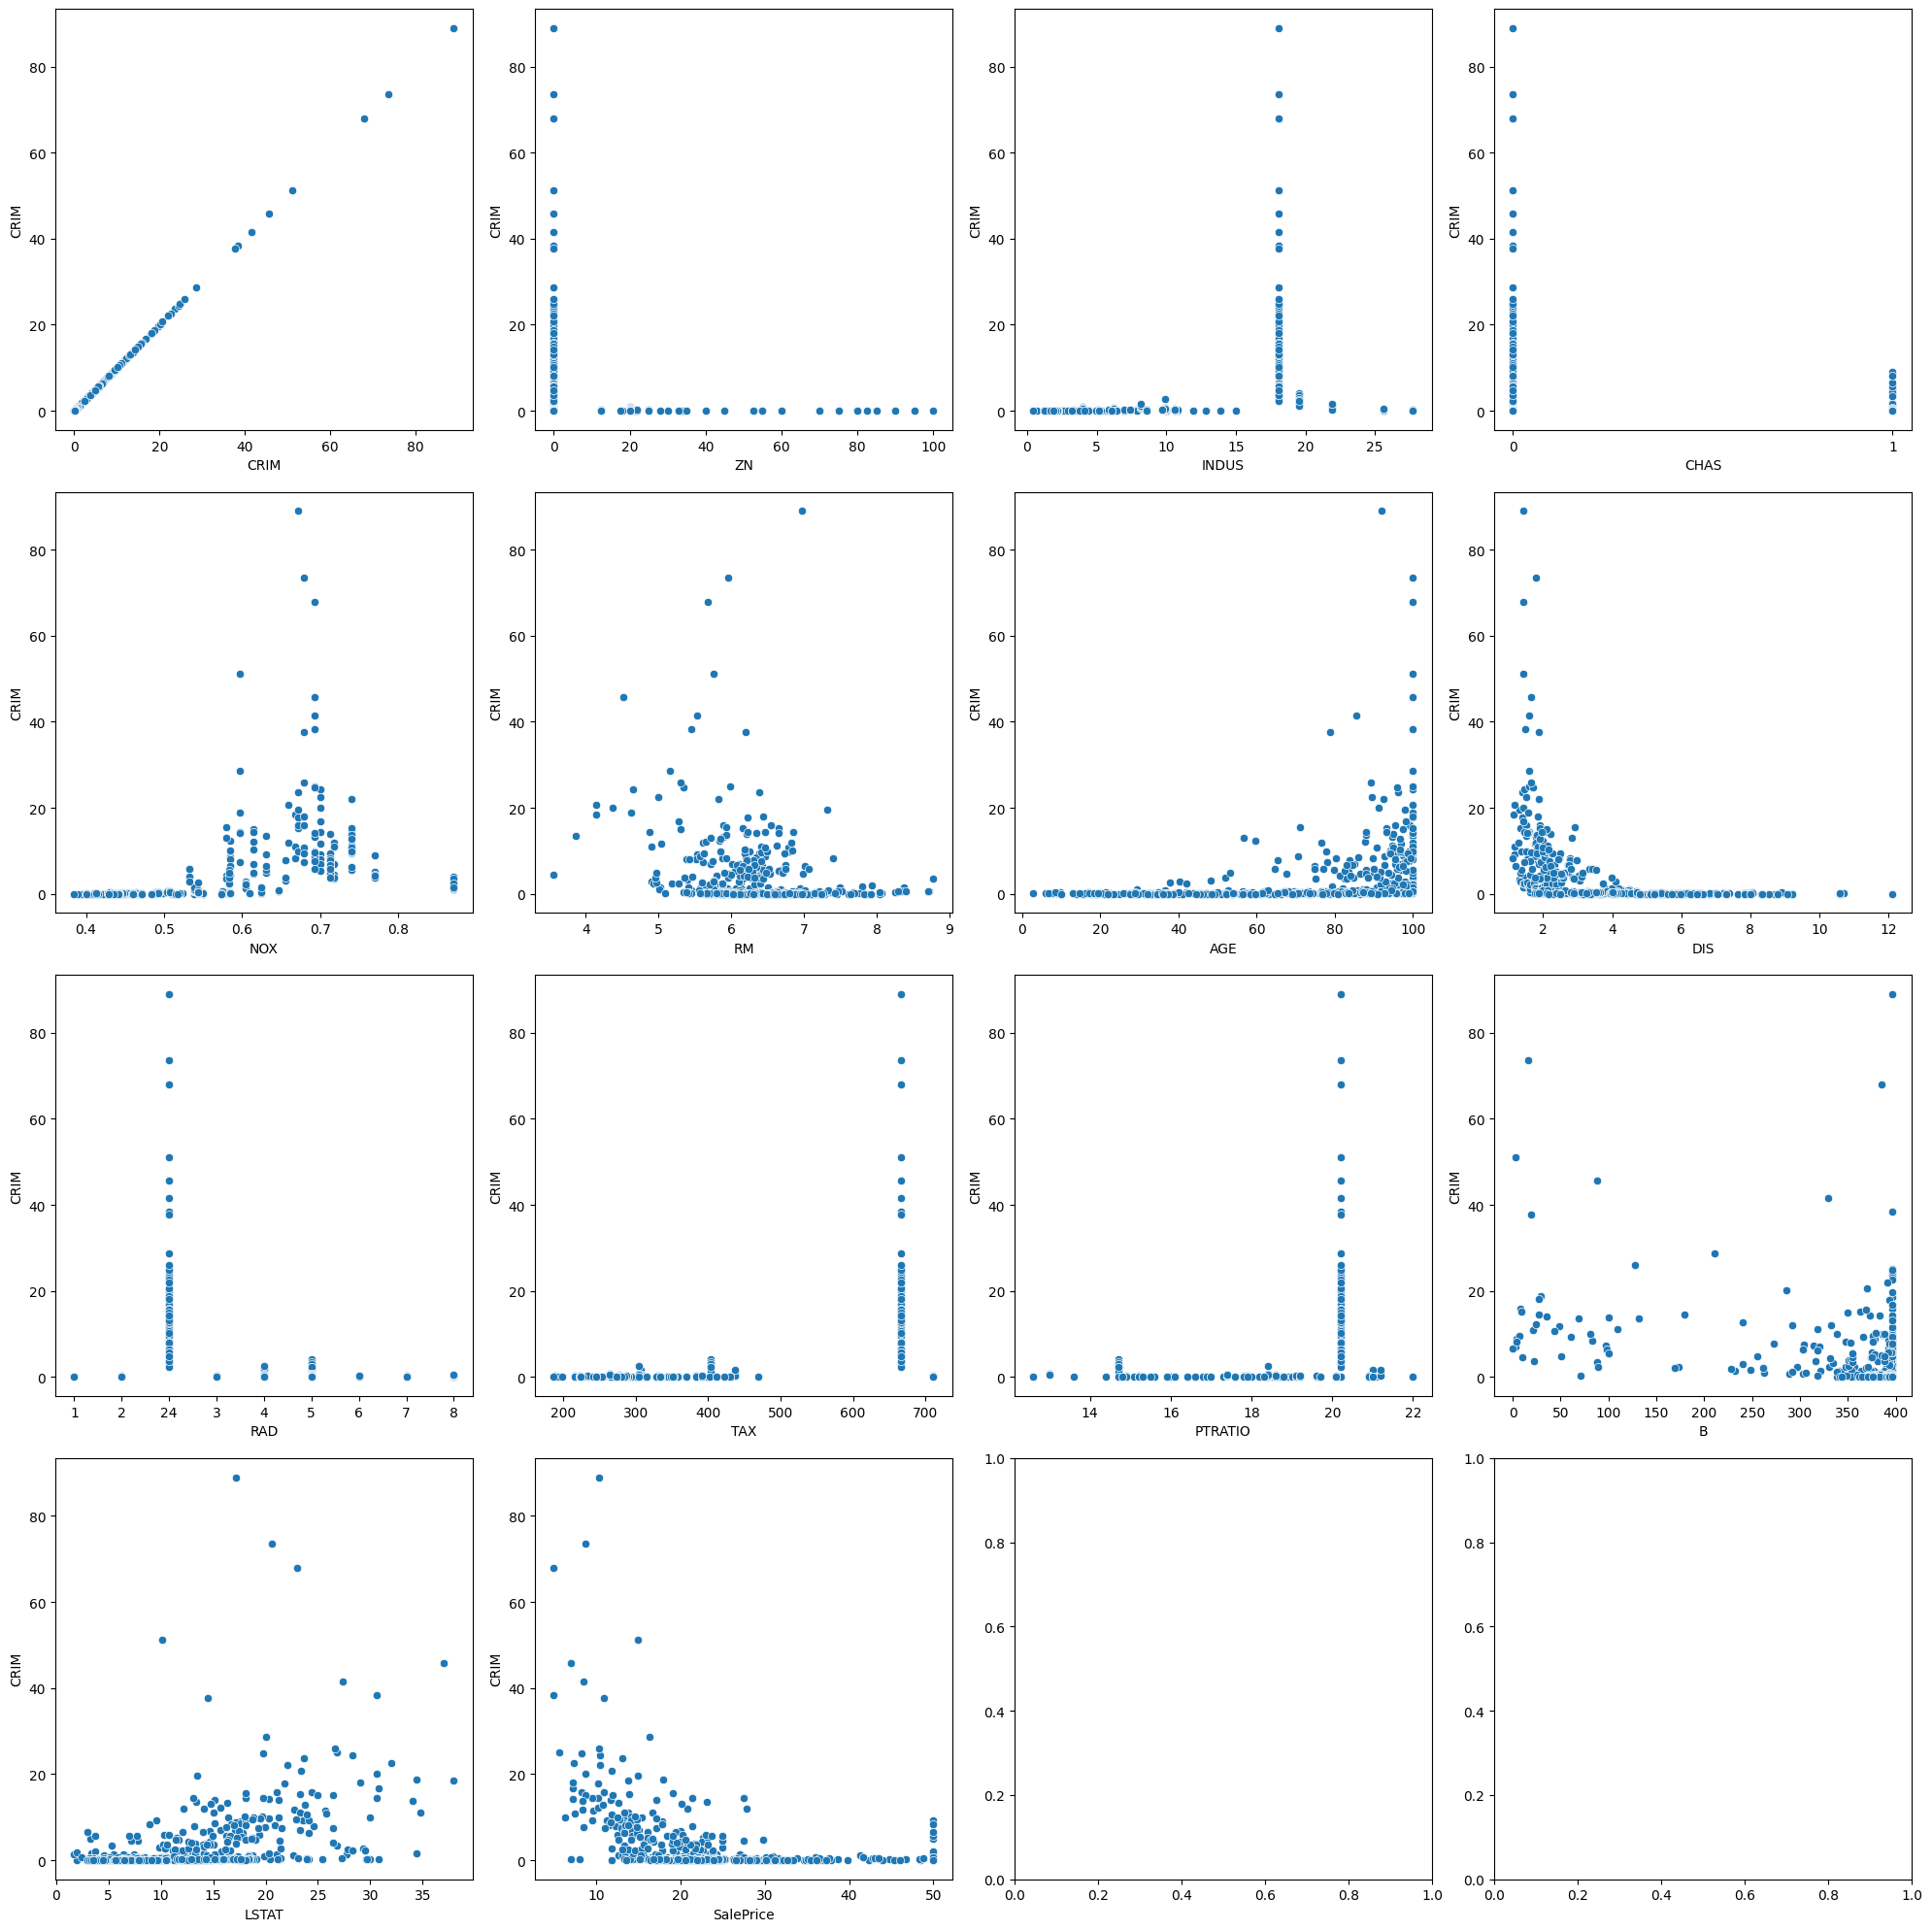

In [ ]:
def pairplots(df, target='SalePrice'):
  n_cols = 4
  n_rows = math.ceil(len(df.columns) / n_cols)

  fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))

  for i, col in enumerate(df.columns):
      row = i // n_cols
      coln = i % n_cols
      sns.scatterplot(y=df[target], x=df[col], ax=axs[row, coln])

  plt.tight_layout()
  plt.show()

pairplots(dataset)

<Axes: xlabel='LSTAT', ylabel='CRIM'>

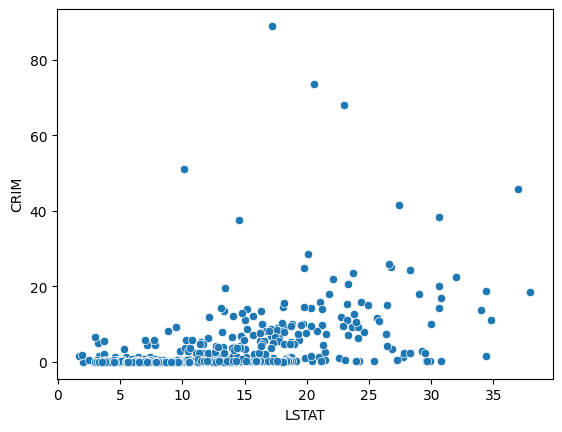

In [ ]:
sns.scatterplot(y=dataset['CRIM'], x=dataset['LSTAT'])
plt.show()
sns.scatterplot(y=dataset['CRIM'], x=dataset['SellPRic'])

As we can see the number of rooms in a house is strongly correlated with the price, as well as the pooper the population the less houses cost in that area.

In [ ]:
def check_skewkur(df,param):
  sns.distplot(df[param], fit=stats.norm)
  fig = plt.figure(figsize = (4,3))
  res = stats.probplot(df[param], plot=plt)

<ipython-input-605-18a25939d302>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[param], fit=stats.norm)


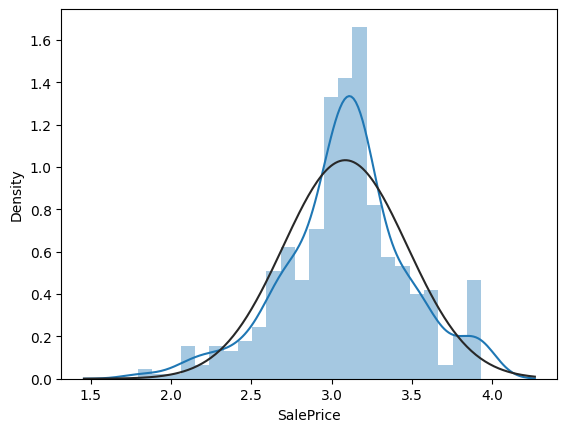

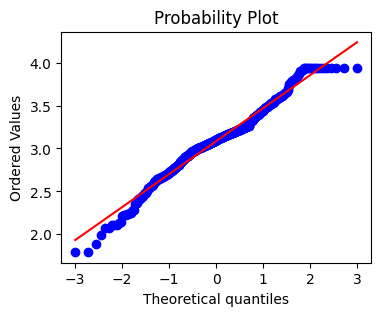

In [ ]:
#Let's log the data
logdf = dataset.copy()
for col in ['LSTAT', 'DIS', 'AGE','B', 'SalePrice', 'TAX']:
  logdf[col] = dataset[col].apply(lambda x: np.log(x+1))

check_skewkur(logdf, 'SalePrice')

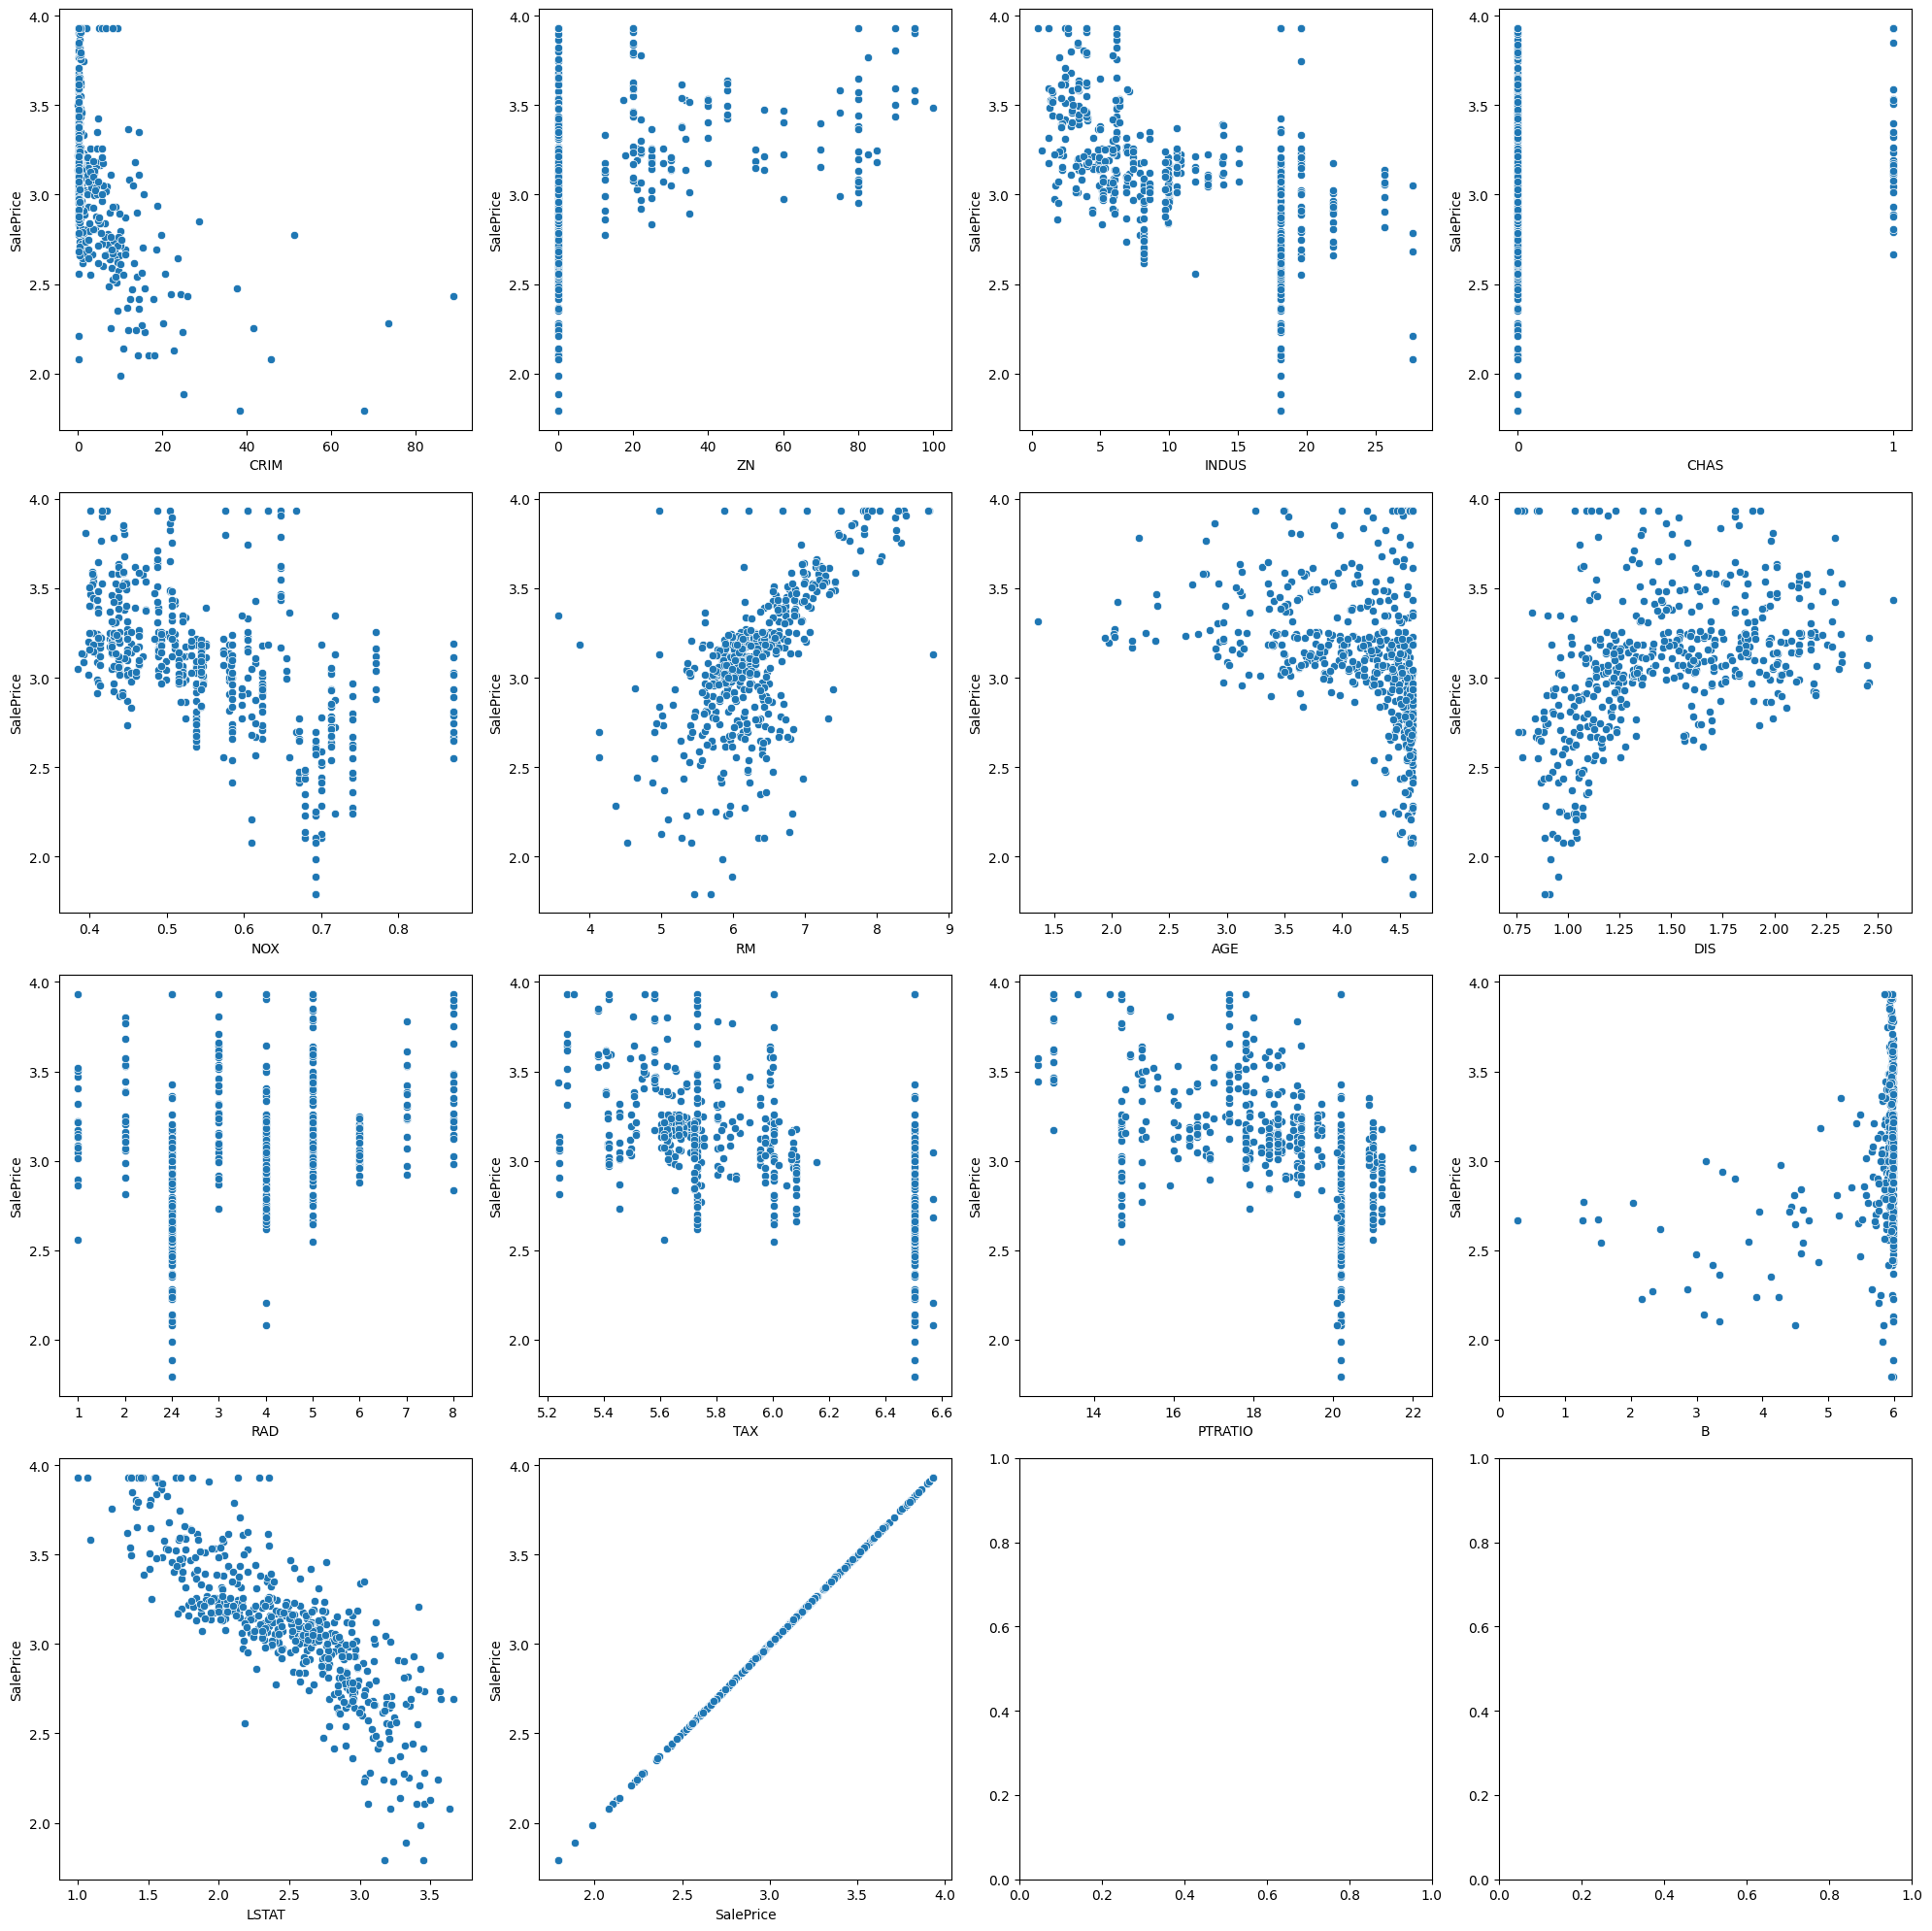

In [ ]:
pairplots(logdf)

#Filter iqr

Let's cut some values of training set

In [ ]:
def cut_iqr(df:pd.DataFrame, col:'str', mult: int = 3)-> pd.DataFrame:
  '''cuts rows to col's iqr max'''
  d=df[col].describe()
  val =(d['50%'] + (d['75%']-d['25%'])) * mult
  return df[df[col] <= val]

##Scale data

In [ ]:
def scale_X(X_train:pd.DataFrame, X_test:pd.DataFrame)-> tuple:
  '''appies scaler to data'''
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test

#Prepare data

In [ ]:
def prepare_data(split:float = 0.2, rand: int = 13, iqr:bool = False) -> tuple:
  '''perform all actions on data to prepare for model'''
  data = X.copy()
  data["SalePrice"] = y.copy()
  data['CRMZN'] = data['CRIM'] + data['ZN']
  if iqr:
    for col in ['CRIM', 'CRMZN']:
      data = cut_iqr(data, col)
  #log data
  for col in ['LSTAT', 'DIS', 'AGE','B', 'SalePrice', 'TAX', 'CRMZN']:
    data[col] = data[col].apply(lambda x: np.log(x+1))
  #split data
  X_train, X_test, y_train, y_test = train_test_split(data.drop(columns =['SalePrice']), data['SalePrice'], test_size=split, random_state = rand)
  #cut iqr

  #  y_train = y_train[y_train.index.isin(X_train.index)]
  #scale
  X_train, X_test = scale_X(X_train, X_test)
  return X_train, X_test, y_train, y_test


In [ ]:
def power_e(ilist:list) -> list:
  """transform col back from log"""
  return [np.e**x for x in ilist]

# Create model

In [ ]:
#take a look at weights and biases
def wnd(model) -> None:
  print('Weights: ', model.coef_)
  print('Bias: ', model.intercept_)

In [ ]:
def print_score(y:pd.Series, y_pred:np.ndarray, name:str = 'Train')-> None:
  print(name + ' MSE: ', mean_squared_error(y, y_pred))
  print(name + ' MAE: ', mean_absolute_error(y, y_pred))
  print(name+ ' R2 score: ', r2_score(y, y_pred))
  print()

In [ ]:
def run_test_model(X_train:pd.DataFrame, X_test:pd.DataFrame, y_train:pd.Series, y_test:pd.Series, model):
  '''trains model and shows score'''
  model.fit(X_train, y_train)

  y_train_pred = np.e** model.predict(X_train)
  y_test_pred = np.e** model.predict(X_test)

  y_train, y_test = power_e([y_train, y_test])
  print_score(y_train, y_train_pred)
  print_score(y_test, y_test_pred, 'Test')
  return model

#Predict values

In [ ]:
models = [Lasso(0.001), Ridge(), LinearRegression()]
names = ['Lasso', 'Ridge', 'Linear']

variables = prepare_data(0.2 , 13, True)
for n in range(len(models)):
  print('Model: ', names[n])
  run_test_model(*variables, models[n])
  print()

Model:  Lasso
Train MSE:  15.880111088772752
Train MAE:  2.579206689583103
Train R2 score:  0.7871644959658709

Test MSE:  10.245753064160606
Test MAE:  2.3077591069322314
Test R2 score:  0.8431375465671629


Model:  Ridge
Train MSE:  15.801537134750463
Train MAE:  2.5860215207850175
Train R2 score:  0.7882175948399783

Test MSE:  10.21298433601194
Test MAE:  2.319593416729391
Test R2 score:  0.8436392357120295


Model:  Linear
Train MSE:  15.783303536777693
Train MAE:  2.5898592231368704
Train R2 score:  0.7884619732950909

Test MSE:  10.282146805334982
Test MAE:  2.332410219121696
Test R2 score:  0.8425803584820644




So we've trained Ridge, Lasso and Linear regressions.
Linear does what linear does, Ridge penalizes for high weights, Lasso - for low and high weight.

But in the end they all have performed quite similarly. Different random state of split influences much more as well as removing iqr.